# **Setup**
 
Reset the Python environment to clear it of any previously loaded variables, functions, or libraries. Then, import the libraries needed to complete the code Professor Melnikov presented in the video.

In [1]:
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity = "all"    # allows multiple outputs from a cell

import pandas as pd, numpy as np, nltk, seaborn as sns, gensim, matplotlib.pyplot as plt, warnings
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
np.__version__, gensim.__version__  # should be >=1.19.5, ==4.*

('1.19.5', '4.2.0')

<hr style="border-top: 2px solid #606366; background: transparent;">


# **Review**

<span style="color:black">In this activity, you'll practice using Gensim methods to understand word similarity and to perform operations on word vectors. In addition, you'll examine the similarity concepts and functions behind the methods you can use in the Gensim package. 
    
Begin by loading the GloVe Word2Vec model and test that it works by retrieving a vector embedding for the word "cat."

In [2]:
# Dictionary-like object. key=word (string), value=trained embedding coefficients (array of numbers)
sFile = "https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-wiki-gigaword-50/glove-wiki-gigaword-50.gz"
%time wv = KeyedVectors.load_word2vec_format(sFile)
wv['cat']    # retrieve a vector for the word "cat"

CPU times: user 41.2 s, sys: 697 ms, total: 41.9 s
Wall time: 42.4 s


array([ 0.45281 , -0.50108 , -0.53714 , -0.015697,  0.22191 ,  0.54602 ,
       -0.67301 , -0.6891  ,  0.63493 , -0.19726 ,  0.33685 ,  0.7735  ,
        0.90094 ,  0.38488 ,  0.38367 ,  0.2657  , -0.08057 ,  0.61089 ,
       -1.2894  , -0.22313 , -0.61578 ,  0.21697 ,  0.35614 ,  0.44499 ,
        0.60885 , -1.1633  , -1.1579  ,  0.36118 ,  0.10466 , -0.78325 ,
        1.4352  ,  0.18629 , -0.26112 ,  0.83275 , -0.23123 ,  0.32481 ,
        0.14485 , -0.44552 ,  0.33497 , -0.95946 , -0.097479,  0.48138 ,
       -0.43352 ,  0.69455 ,  0.91043 , -0.28173 ,  0.41637 , -1.2609  ,
        0.71278 ,  0.23782 ], dtype=float32)

<h3 style="color:black"> Using Cosine Similarity to Identify Similar Words</h3>

<span style="color:black"> One metric for identifying semantically similar words is [cosine similarity](https://www.machinelearningplus.com/nlp/cosine-similarity/). Cosine similarity values range from -1 to 1, with the score of 1 representing perfect similarity (such as the similarity of a word with itself) and a score of -1 representing perfect dissimilarity.
    
<span style="color:black">From the Gensim library, the `most_similar()` method identifies the top $n$ most similar words for a given word. The method converts the given word into a word vector and then computes cosine similarities of that vector with each of the 400K vectors in the model. Similarities are then ordered in decreasing order and the highest $n$ cosine similarity scores along with the associated word are returned. You can choose how many of the most similar words to return with the `topn` argument.

In [3]:
wv.most_similar(positive='cornell', topn=10)  # returns top 10 most similar words

[('yale', 0.8834298253059387),
 ('harvard', 0.8587191104888916),
 ('princeton', 0.8516749739646912),
 ('johns', 0.8299359083175659),
 ('graduate', 0.8046482801437378),
 ('university', 0.783868134021759),
 ('graduated', 0.7779932618141174),
 ('ph.d.', 0.7745646238327026),
 ('professor', 0.7677767872810364),
 ('brigham', 0.7653858065605164)]

<span style="color:black">Often, you do not need to calculate the cosine similarity of a word to all of the words in a dictionary. Gensim allows you to restrict the search set with `most_similar_to_given()` method.


In [4]:
LsWords = ['jazz','music','professor','wave','new-york','science','surf']
wv.most_similar_to_given(key1='cornell', keys_list=LsWords)

'professor'

You can obtain the same results by first finding an intersection between words in `LsWords` and the model's vocabulary using cosine similarity directly, instead of the `most_similar_to_given` method. The `similarity()` method is a wrapper for the cosine similarity function. It takes a pair of words, finds their word vectors — say $x,y\in\mathbb{R}^{50}$ — and then computes their cosine similarity as 
$$\frac{x'y}{||x||\cdot ||y||}$$

where $||x||:=\sqrt{x'x}$ is the norm of $x$ and $x'x=x\bullet x$ is the dot product of $x$ with itself.

<span style="color:black"> To find the most similar words with the `similarity` method, retrieve all vectors for the resulting words and the word vector for the query word `key1`. Then, compute cosine similarities for all pairs of the query vector and all retrieved vectors, and find the word with the largest cosine similarity.  

Below we order the words as per their decreasing cosine similarity to `'cornell'`. 

In [5]:
# order words by descending similarity to 'cornell'
LsWords.append('cornell')
sorted([(wv.similarity('cornell', w), w) for w in LsWords], reverse=True) 

[(1.0, 'cornell'),
 (0.76777685, 'professor'),
 (0.65508866, 'science'),
 (0.42406917, 'jazz'),
 (0.34651953, 'music'),
 (0.14060146, 'new-york'),
 (0.029297035, 'surf'),
 (-0.06155849, 'wave')]

<span style="color:black">Since `'cornell'` is also on this list, it turns up as the most similar with a cosine similarity score of 1. The next word is `'professor'`, just like we saw in the previous example.

<h3 style="color:black"> Visualizing Word Vectors by Reducing Dimensions With Principal Component Analysis</h3>

<span style="color:black"> One challenge with 50-dimensional vectors is that you cannot view them directly in 50-dimensional space. One way to visualize them is to perform a dimension reduction technique called principal component analysis ([PCA](https://www.machinelearningplus.com/nlp/cosine-similarity/)). PCA takes the 50-dimensional <b>correlated</b> vectors for $n$ words and outputs 50-dimensional <b>uncorrelated</b> vectors, which are called principal components (PCs). You'll examine PCA in greater detail in a subsequent course, but this is the level at which you'll need to understand this technique in this course. 

The absence of correlation in PCs allows you to do amazing things, such as dropping all but two dimensions while still keeping the most meaningful dimensions. Now these new 2D vectors, which represent the $n$ words in a lower-dimensional space, can be plotted.

In [6]:
def ShowPCA(mdl, LsWords=None, sample=0):
    arrWV = np.array([mdl[w] for w in LsWords])
    twodim = PCA().fit_transform(arrWV)[:,:2]
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    
    for word, (x,y) in zip(LsWords, twodim):
        plt.text(x+0.05, y+0.05, word)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid()
    plt.show()

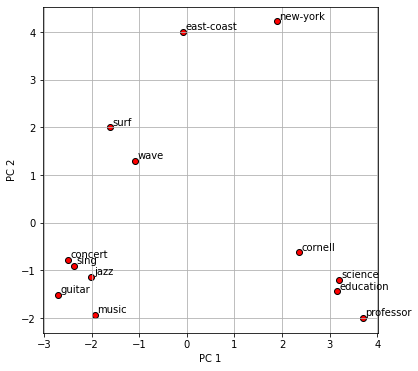

In [7]:
ShowPCA(wv, LsWords + ['education','east-coast','guitar','sing','concert'])

<span style="color:black">If these new vectors represent the words correctly, then the words should group together with their semantically similar counterparts in the plot. This is precisely what you observe: Education terms are grouped together and music terms are grouped together. Notice that education and music have similar second coordinate values but differ dramatically in the first coordinate. This means that the first coordinate still differentiates these classes of words, but the second coordinate does not.
    
## Performing Word Vector Arithmetic

<span style="color:black">Let's take this to the next step and perform semantic arithmetic on vectors. This is just one example of many things you can do to these vectors - for more exciting Word2Vec discoveries, see the *Results* section of Tomas Mikolov's  [original paper](https://arxiv.org/abs/1301.3781). 
    
<span style="color:black">Use `most_similar()` to add vectors of the words "king" and "woman" and subtract the vector of "man."

In [8]:
print( wv.most_similar(positive=['king', 'woman'], negative=['man'], topn=5) )  # wv['king'] - wv['man'] + wv['woman']

[('queen', 0.8523604273796082), ('throne', 0.7664334177970886), ('prince', 0.7592144012451172), ('daughter', 0.7473883628845215), ('elizabeth', 0.7460219860076904)]


<span style="color:black">Repeat this and look for the word with the vector most similar to vec(actor) + vec(woman) - vec(man), where vec(actor) is the vector of the word "actor."

In [9]:
print( wv.most_similar(positive=['actor', 'woman'], negative=['man']) )   # wv['actor'] + wv['woman'] - wv['man']

[('actress', 0.9418652653694153), ('starred', 0.7999047040939331), ('starring', 0.7790413498878479), ('comedian', 0.7691040635108948), ('actresses', 0.7551373839378357), ('singer', 0.7492478489875793), ('entertainer', 0.7485175728797913), ('dancer', 0.7392400503158569), ('screenwriter', 0.7320058345794678), ('filmmaker', 0.7196097373962402)]


<span style="color:black">Only the top few closest vectors are returned. "Actress" seems to make sense here. Let's try the same algebra with names of the U.S. presidents.

In [10]:
print( wv.most_similar(positive=['obama', 'clinton'], negative=['reagan'], topn=5) )  # Obama to Clinton as Reagan to ...

[('bush', 0.8469876646995544), ('barack', 0.8274411559104919), ('hopeful', 0.7956836223602295), ('mccain', 0.7914982438087463), ('gore', 0.7858978509902954)]


<span style="color:black">The method `doesnt_match()` allows you to identify words which do not belong to the list. 

In [11]:
# warnings.simplefilter(action='ignore', category=FutureWarning) # in case Gensim throws a Future warning
wv.doesnt_match("breakfast milk dinner lunch".split())  # which vector is the farthest from the vector sum?

'milk'

"Milk" doesn't belong in this list as much as "breakfast," "lunch," and "dinner" do. The latter represent a type of meal, whereas "milk" is a type of food.

<hr style="border-top: 2px solid #606366; background: transparent;">

# **Optional Practice**

Below, you'll use `Gensim` functions to experiment with determining word similarity and vector arithmetic.

As you work through these tasks, check your answers by running your code in the *#check solution here* cell, to see if you’ve gotten the correct result. If you get stuck on a task, click the See **solution** drop-down to view the answer.

## Task 1

Find the three most similar words to "space" in the model's vocabulary. 

<b>Hint:</b> Try the <code>most_similar()</code> method.


In [ ]:
# your solution goes here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
wv.most_similar(positive='space', topn=3)
    </pre>
    </details> 
</font>
<hr>

## Task 2

Find the five words that are most similar to "wedding" and "bride."

<b>Hint:</b> Try the <code>most_similar()</code> method. 


In [ ]:
# your solution goes here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
print( wv.most_similar(positive=['wedding', 'bride'], topn=5) )
    </pre>
    </details> 
</font>
<hr>

## Task 3

Find the five words that are most similar to "australia" and "russian," but not "russia."

<b>Hint:</b> Try the <code>most_similar()</code> method.

In [ ]:
# your solution goes here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
print( wv.most_similar(positive=['australia', 'russian'], negative=['russia'], topn=5) )
    </pre>
    </details> 
</font>
<hr>

## Task 4

What is the most likely word you will get if you subtract (i.e., remove) "texas" from "california" and "texan"?

<b>Hint:</b> Try the <code>most_similar()</code> method.


In [ ]:
# your solution goes here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
print( wv.most_similar(positive=['california', 'texan'], negative=['texas'], topn=1) )
    </pre>
    </details> 
</font>
<hr>

## Task 5

Remove "scientist" from "einstein" and add "violinist"; who is recommended by the Word2Vec model?

<b>Hint:</b> Try the <code>most_similar()</code> method.


In [ ]:
# your solution goes here

<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
print( wv.most_similar(positive=['violinist', 'einstein'], negative=['scientist'], topn=5) )
    </pre>
    </details> 
</font>
<hr>

## Task 6

What is the word most similar to "*platinum*" and "*membership*"?

<b>Hint:</b> Try the <code>most_similar()</code> method.


In [ ]:
# your solution goes here


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
print( wv.most_similar(positive=['platinum', 'membership'], topn=1) )
    </pre>
    </details> 
</font>
<hr>

## Task 7

Use the appropriate method to identify the mismatched word in the list `"cornell university professor exam research crab".split()`.

<b>Hint:</b> Try the <code>doesnt_match()</code> method. 

In [ ]:
# your solution goes here 


<font color=#606366>
    <details><summary><font color=#b31b1b>▶ </font>See <b>solution</b>.</summary>
    <pre>
wv.doesnt_match("cornell university professor exam research crab".split())  
    </pre>
    </details> 
</font>
<hr>